<a href="https://colab.research.google.com/github/bingsen-wang/Electric-Machines/blob/main/ElectricMachines_SalientTwoPoleSynchronousMotorOverExcitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Synchronous Electric Machines: Salient 2-Pole in Motoring Mode with Over Excitation</h1></b>

Dr. Bingsen Wang

8/5/2024
</center>

#Python Code
The Python code illustrates the salient 2-pole synchronous electric machines.

0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
0


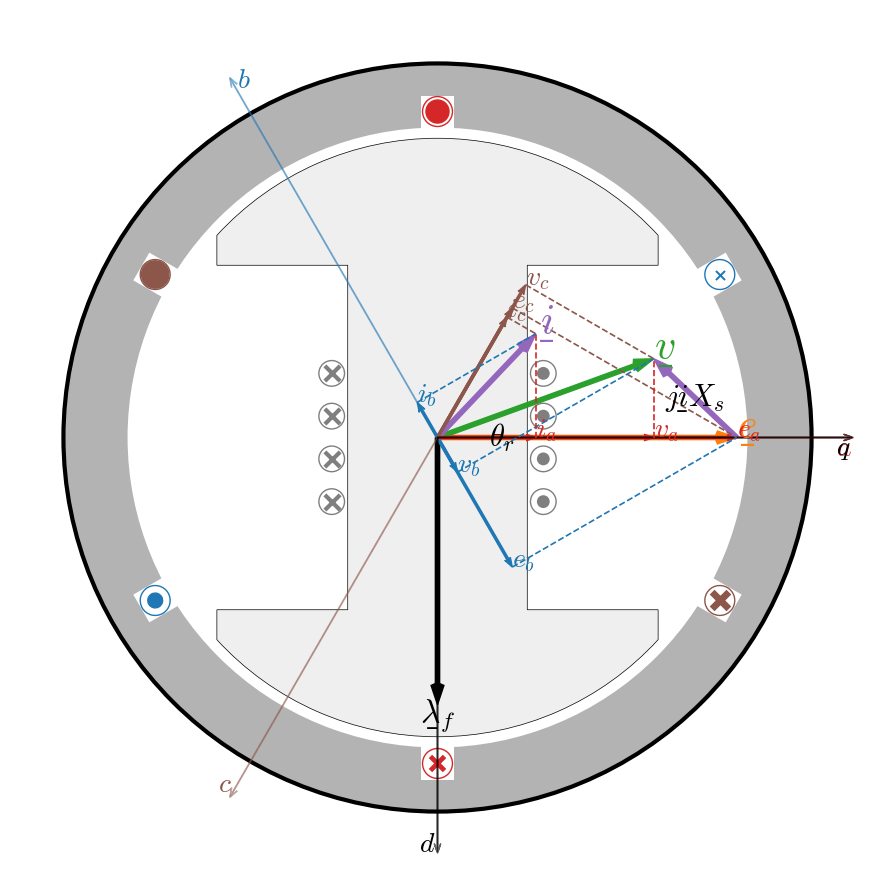

In [114]:
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,exp,angle,array,sqrt
from numpy import heaviside as hs
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib.patches import FancyArrow as fa
from matplotlib.path import Path
from matplotlib.patches import PathPatch,Arc
from matplotlib.collections import PathCollection as pc
from matplotlib import animation,transforms,colors
plt.rcParams.update({"font.family" : "sans serif","mathtext.fontset" : "cm"})

def ph2abc(t,w,ph): # phasor to abc
    return abs(ph)*array([cos(w*t+angle(ph)-k*2*pi/3) for k in range(3)])

def abc2ab(abc): #Clarke transformation, abc to alpha-beta
  return sum(2/3*abc[k]*exp(1j*k*2*pi/3) for k in range(3))

def axis_reset(ax): #clear axis for redrawing
  xy=ax.axis(); ax.cla(); ax.axis('off'); ax.set(xlim=xy[:2],ylim=xy[-2:])
  return

def draw_abc_axes(ax,theta,l,labels,colors,alpha=1,width=.005,zorder=2):
  for k in range(3):
    rot = transforms.Affine2D().rotate(2*pi/3*k+theta)+ax.transData
    ax.add_patch(fa(0,0,l,0,width=width,head_width=.06,overhang=.8,color=colors[k],
                    alpha=alpha,transform=rot,zorder=zorder))
    ax.text(l,-0.1,labels[k],color=colors[k],size=20,transform=rot,ha='center',va='center')
  return

def draw_qd_axes(ax,theta,l,labels,colors,alpha=1,width=.005,zorder=2):
  for k in range(2):
    rot = transforms.Affine2D().rotate(-pi/2*k+theta)+ax.transData
    ax.add_patch(fa(0,0,l,0,width=width,head_width=.06,overhang=.8,color=colors[-2],
                    alpha=alpha,transform=rot,zorder=zorder))
    ax.text(l,-.1,labels[k],color=colors[-2],size=20,transform=rot,ha='center',va='center')
  return

def draw_coductors_in_slots(ax,r,theta,clst,stator=1): #stator=-1 for rotor
  for k in range(6):
    rot = transforms.Affine2D().rotate(pi/3*k+theta)+ax.transData
    ax.add_patch(mp.Rectangle((r-.2+.1*stator,-.15),.4,.3,fc=clst[-1],transform=rot)) #slots
    ax.add_patch(mp.Circle((r+.15*stator,0),.14,color=clst[(1-k)%3],fc='none',lw=1,
                           transform=rot)) #conductors
  return
def draw_current_polarities(ax,r,clst,theta=0,abc=[1,1,1]): #current polarities
  for k in range(3):
    rot = transforms.Affine2D().rotate(2*pi/3*k+pi/2+(1-hs(abc[k],0))*pi+theta)+ax.transData
    ax.add_patch(mp.Circle((r,0),.13*sqrt(abs(abc[k])),color=clst[k],transform=rot)) #dot
    rot = transforms.Affine2D().rotate(2*pi/3*k+3*pi/2+(1-hs(abc[k],0))*pi+theta)+ax.transData
    ax.scatter(r,0,s=150*abs(abc[k]),marker='x',lw=5*abs(abc[k]),color=clst[k],transform=rot)#cross
  return

def draw_stator(ax,ord,ird,clst,alpha=1): #stator with axes
  """ord: outter radius; ird: inner radius"""
  ax.add_patch(mp.Circle((0,0),ord,color=clst[-2],lw=3,fc=(.7,.7,.7,1),alpha=alpha))
  ax.add_patch(mp.Circle((0,0),ird,color=clst[-2],lw=0,fc=clst[-1],alpha=alpha))
  draw_coductors_in_slots(ax,ird,pi/6,clst)
  return

def draw_rotor(ax,r,clst,theta=0,alpha=1): #rotor w/ rotor/stator axes
  a = 95 # pole pitch from a to 180-a degrees
  x,y=exp(-1j*.5*a/180*pi).real,exp(-1j*.5*a/180*pi).imag
  rot = transforms.Affine2D().rotate(theta+pi/2).scale(r)+ax.transData
  v,c=[],[]
  d = .3 #rotor pole dimension
  for k in range(2): #salient rotor shape with arcs and lines
    pts = np.array([-x+.1+1j*y,-x+.1-1j*d,x-.1-1j*d,x-.1+1j*y])*exp(1j*pi*k)
    v.append(list(zip(pts.real,pts.imag))); c.extend([Path.LINETO]*5)
    v.append(Path.arc(-a/2+180*k,a/2+180*k).vertices)
    c.extend(Path.arc(-a/2+180*k,a/2+180*k).codes[1:])
  ax.add_patch(PathPatch(Path(list(np.vstack(v))+[[0,0]],([Path.MOVETO]+c[1:]+[Path.CLOSEPOLY])),
                         ec=clst[-2],fc=(.8,.8,.8,.3),lw=.5,transform=rot)) #rotor shape
  draw_abc_axes(ax,0,3.8,['$a$','$b$','$c$'],clst,width=.005,alpha=.5) #stator axes
  draw_qd_axes(ax,theta,3.8,['$q$','$d$'],clst,width=.01,alpha=.6) #rotor axes
  ax.add_patch(mp.Arc((0,0),1,1,theta2=theta*180/pi,color=clst[-2]))
  rot = transforms.Affine2D().rotate((theta%(2*pi))/2)+ax.transData
  ax.text(.6,0,r'$\theta_r$',size=22,transform=rot,va='center',ha='center')
  rot = transforms.Affine2D().rotate(theta)+ax.transData
  for k in range(4):
    ax.add_patch(mp.Circle((r*d+.15,.6-k*.4),.12,ec=clst[-2],alpha=.5,fc='none',transform=rot))
    ax.add_patch(mp.Circle((r*d+.15,.6-k*.4),.06,fc=clst[-2],alpha=.5,ec='none',transform=rot))#dots
    ax.add_patch(mp.Circle((-r*d-.15,.6-k*.4),.12,ec=clst[-2],alpha=.5,fc='none',transform=rot))
    ax.scatter(-r*d-.15,.6-k*.4,s=120,marker='x',lw=3,color=clst[-2],alpha=.5,transform=rot)#crosses
  return

def draw_vectors(ax,abc,ab,clst,theta=0,vns=['']):
  t=['a','b','c']
  rot = transforms.Affine2D().rotate(theta)+ax.transData
  as1 = {'width':.04,'length_includes_head':True,'overhang':-.1} #arr style
  as2 = {'width':.02,'length_includes_head':True,'overhang':.3} #arr style
  ax.add_patch(fa(0,0,0,-2.5,**as1,color=clst[-2],transform=rot)) #rotor flux vector
  ax.text(0,-2.6,r'$\lambda\underbar_f$',size=24,color=clst[-2],transform=rot,va='center',ha='center')
  for k in range(3):
    ax.add_patch(fa(0,0,ab[k].real,ab[k].imag,**as1,color=clst[-3-k])) #i,v,e-vectors
    ax.text(ab[k].real+.1,ab[k].imag+.1,'$'+vns[k]+r'\underbar$',size=30,color=clst[-3-k],va='center',ha='center')
    for kk in range(3):
      rot = transforms.Affine2D().rotate(kk*2*pi/3)+ax.transData
      ax.add_patch(fa(0,0,abc[k][kk],0,**as2,color=clst[kk],transform=rot)) #abc vec
      ax.text(abc[k][kk],0,'$'+vns[k]+'_'+t[kk]+'$',size=20,color=clst[kk],transform=rot) #abc labels
      ax.plot([abc[k][kk]*cos(kk*2*pi/3),ab[k].real],[abc[k][kk]*sin(kk*2*pi/3),ab[k].imag],'--',color=clst[kk],lw=1.2)
  ax.add_patch(fa(ab[0].real,ab[0].imag,(ab[1]-ab[0]).real,(ab[1]-ab[0]).imag,**as1,color=clst[-5])) #jIX
  ax.text((ab[0]+ab[1]).real/2,(ab[0]+ab[1]).imag/2,r'$ji\underbar X_s$',size=22,color=clst[-2],va='center',ha='center')
  return

#parameters
Nfps = 1200 #number of frames
ord_s,ird_s,ord_r = 3.5,2.9,2.8 #stator outter/inner radi, rotor outter radius
w,Xs,Vph,Eph=2*pi*60,.8,exp(1j*pi*20/180),1.3 #stator frequency,reactance,voltage phasor, bemf phasor
Iph = (Vph-Eph)/(1j*Xs)
ks = 2.8/max([abs(Iph),abs(Eph),abs(Vph)])#scale factor for drawing
t=linspace(0,2*pi/w,Nfps)
i_abc,v_abc,e_abc = ks*ph2abc(t,w,Iph),ks*ph2abc(t,w,Vph),ks*ph2abc(t,w,Eph) #abcs
i_ab,v_ab,e_ab = ks*Iph*exp(1j*w*t),ks*Vph*exp(1j*w*t),ks*Eph*exp(1j*w*t) #svs

#plotting
xylim = [[-4,4] for _ in range(2)]
clst=['tab:red','tab:blue','tab:brown','tab:purple','tab:green','tab:orange','k','w'] #colors light bg
fig = plt.figure(figsize=(9,9))
axs,lines = [[] for _ in range(2)]
for k in range(2):
  axs.append(fig.add_axes((.025,.025,.95,.95),xlim=xylim[0],ylim=xylim[1],fc='none'))
  axs[k].axis('off')
for k in range(3):
  rot=transforms.Affine2D().rotate_around(0,0,2*pi/3*k-pi/2)+axs[0].transData
  lines.append(axs[0].plot([],[],'-',lw=3,transform=rot,color=clst[k],alpha=0.5)[0])
  lines.append(axs[0].plot([],[],'-',lw=2,transform=rot,color=clst[k],alpha=0.8)[0])
  lines.append(axs[0].plot([],[],'-',lw=1.5,transform=rot,color=clst[k],alpha=1)[0])
  lines.append(axs[0].plot([],[],'--',lw=1,transform=rot,color=clst[k],alpha=0.8)[0])
  lines.append(axs[0].plot([],[],'--',lw=1,transform=rot,color=clst[k],alpha=0.8)[0])
  lines.append(axs[0].plot([],[],'--',lw=1,transform=rot,color=clst[k],alpha=0.8)[0])

kt = .7*w/(2*pi)*ird_s #time axis scale to fit in the drawing area
# animation function. This is called sequentially
def animate(i):
  # i=59
  if i%50==0: print(i)
  axis_reset(axs[1]) #clear axis
  draw_current_polarities(axs[1],ird_s+.15,clst,abc=i_abc[:,i]/abs(Iph*ks)) #stator currents
  draw_rotor(axs[1],ord_r,clst,theta=w*t[i])
  draw_vectors(axs[1],[e_abc[:,i],v_abc[:,i],i_abc[:,i]],[e_ab[i],v_ab[i],i_ab[i]],
               clst,vns=['e','v','i'],theta=w*t[i]) #
  for k in range(3):
    lines[6*k].set_data(t[:i+1]*kt, e_abc[k,:i+1])
    lines[6*k+1].set_data(t[:i+1]*kt, v_abc[k,:i+1])
    lines[6*k+2].set_data(t[:i+1]*kt, i_abc[k,:i+1])
    lines[6*k+3].set_data([0,t[i]*kt], [e_abc[k,i],e_abc[k,i]])
    lines[6*k+4].set_data([0,t[i]*kt], [v_abc[k,i],v_abc[k,i]])
    lines[6*k+5].set_data([0,t[i]*kt], [i_abc[k,i],i_abc[k,i]])
  return
draw_stator(axs[0],ord_s,ird_s,clst)
anim = animation.FuncAnimation(fig, animate, frames=Nfps)
anim.save("ElectricMachine_SalientTwoPoleOverExcitation.mp4", writer=animation.FFMpegWriter(fps=40),dpi = 200)